In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Loading data

In [33]:
# Загрузка и предобработка данных CIFAR-10
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [34]:
# Загрузка предобученной модели ResNet18 и модификация последнего слоя
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Замораживаем параметры

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Заменяем последний слой под CIFAR-10

In [35]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Visualization

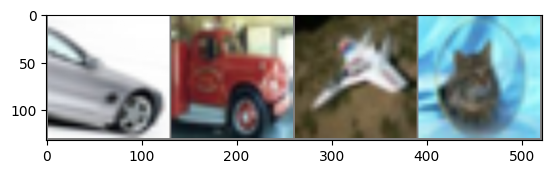

car   truck plane cat  


In [36]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Получаем некоторые случайные обучающие изображения
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Выводим изображения
imshow(torchvision.utils.make_grid(images[:4]))
# Печатаем метки для каждого изображения
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [37]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    model.train() 
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            loss.backward()  
            optimizer.step() 

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')

In [41]:
def evaluate_model(model, dataloader):
    model.eval()  # Переключаем модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов для ускорения
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Вычисляем точность на обучающем наборе данных
train_accuracy = evaluate_model(model, trainloader)
print(f'Train Accuracy: {train_accuracy:.2f}%')

# Вычисляем точность на тестовом наборе данных
test_accuracy = evaluate_model(model, testloader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Train Accuracy: 80.78%
Test Accuracy: 79.39%


In [38]:
train_model(model, criterion, optimizer, num_epochs=4)

Epoch 1/4, Loss: 0.7861
Epoch 2/4, Loss: 0.6157
Epoch 3/4, Loss: 0.5916
Epoch 4/4, Loss: 0.5851
Training complete


## Testing

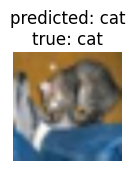

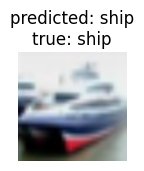

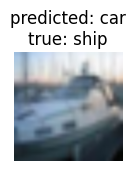

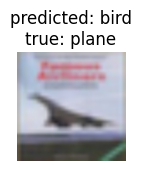

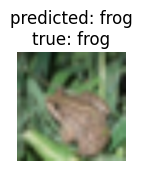

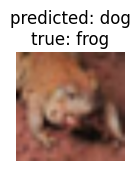

In [39]:
def test_and_visualize_model(model, num_images=6):
    model.eval() 
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():  # Отключаем вычисление градиентов
        for i, (inputs, labels) in enumerate(testloader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}\ntrue: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

test_and_visualize_model(model)

In [40]:
def calculate_accuracy(model, dataloader):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов для ускорения
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Вызываем функцию для расчета точности на тестовом наборе данных
test_accuracy = calculate_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {test_accuracy:.2f}%')

Accuracy of the model on the test images: 79.39%
